# Dog breed classification

In [1]:
import numpy as np
from glob import glob
from keras.utils import np_utils
from sklearn.datasets import load_files

# load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)

    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dog_dataset/train')
valid_files, valid_targets = load_dataset('dog_dataset/valid')
test_files, test_targets   = load_dataset('dog_dataset/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dog_dataset/train/*/"))]

# statistics
print('Total dog categories: %d' % len(dog_names))
print('Total dog images: %s\n' % len(np.hstack([train_files, valid_files, test_files])))
print('Training dog images: %d' % len(train_files))
print('Validation dog images: %d' % len(valid_files))
print('Test dog images %d'% len(test_files))

Using TensorFlow backend.


Total dog categories: 133
Total dog images: 8351

Training dog images: 6680
Validation dog images: 835
Test dog images 836


In [3]:
# Download pre trained ResNet-50 model
from keras.applications.resnet50 import ResNet50

ResNet50_model = ResNet50(weights='imagenet')

In [28]:
from tqdm import tqdm
from keras.preprocessing import image  

# Load an resize the image to 224 x 224
def path_to_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)

    return np.expand_dims(x, axis=0)

def paths_to_image(img_paths):
    list_of_tensors = [path_to_image(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [29]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    #image prediction
    img = preprocess_input(path_to_image(img_path))
    return np.argmax(ResNet50_model.predict(img))

In [6]:
# return true if we have detected a dog
def detect_dog(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

In [9]:
# Pre-process the data 
from PIL import ImageFile                              
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# divide pixels by 255
train_tensors = paths_to_image(train_files).astype('float32')/255
valid_tensors = paths_to_image(valid_files).astype('float32')/255
test_tensors  = paths_to_image(test_files).astype('float32')/255

100%|██████████| 836/836 [00:07<00:00, 117.77it/s]


In [15]:
# Use bottleneck features from another model

bottleneck_features = np.load('bottleneck_features/DogVGG19Data.npz')
train_VGG19 = bottleneck_features['train']
valid_VGG19 = bottleneck_features['valid']
test_VGG19  = bottleneck_features['test']

In [16]:
# Define model
latest_model = Sequential()

input_shape = train_VGG19.shape[1:]
latest_model.add(GlobalAveragePooling2D(input_shape=input_shape))

latest_model.add(Dense(512, activation='relu'))
latest_model.add(Dropout(0.5))
latest_model.add(Dense(256, activation='relu'))
latest_model.add(Dropout(0.5))
latest_model.add(Dense(128, activation='relu'))
latest_model.add(Dropout(0.2))
latest_model.add(Dense(133, activation='softmax'))

latest_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
__________

In [17]:
# Compile
from keras import optimizers

latest_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [19]:
# Train model
from keras.callbacks import EarlyStopping, ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.vg19.hdf5', 
                               verbose=1, save_best_only=True)

earlystop = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=10,
                          verbose=1, mode='auto')
checkpointer_list = [checkpointer, earlystop]

epochs     = 100
batch_size = 1024

latest_model.fit(train_VGG19, train_targets, 
          validation_data=(valid_VGG19, valid_targets),
          epochs=epochs, batch_size=batch_size, callbacks=checkpointer_list, verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/100
6680/6680 [==============================] - 2s - loss: 7.9923 - acc: 0.0102 - val_loss: 4.7803 - val_acc: 0.0407
Epoch 2/100
6680/6680 [==============================] - 1s - loss: 4.9977 - acc: 0.0171 - val_loss: 4.6826 - val_acc: 0.0874
Epoch 3/100
6680/6680 [==============================] - 1s - loss: 4.8039 - acc: 0.0302 - val_loss: 4.5130 - val_acc: 0.1617
Epoch 4/100
6680/6680 [==============================] - 1s - loss: 4.5724 - acc: 0.0584 - val_loss: 4.2379 - val_acc: 0.2251
Epoch 5/100
6680/6680 [==============================] - 1s - loss: 4.3393 - acc: 0.0901 - val_loss: 3.8095 - val_acc: 0.2946
Epoch 6/100
6680/6680 [==============================] - 1s - loss: 4.0023 - acc: 0.1419 - val_loss: 3.3310 - val_acc: 0.3713
Epoch 7/100
6680/6680 [==============================] - 1s - loss: 3.6495 - acc: 0.1870 - val_loss: 2.9100 - val_acc: 0.4347
Epoch 8/100
6680/6680 [==============================] - 1s - loss: 3.3

6680/6680 [==============================] - 1s - loss: 1.2592 - acc: 0.6298 - val_loss: 0.8647 - val_acc: 0.7557
Epoch 28/100
6680/6680 [==============================] - 1s - loss: 1.2196 - acc: 0.6341 - val_loss: 0.8570 - val_acc: 0.7665
Epoch 29/100
6680/6680 [==============================] - 1s - loss: 1.2126 - acc: 0.6395 - val_loss: 0.8466 - val_acc: 0.7497
Epoch 30/100
6680/6680 [==============================] - 1s - loss: 1.1538 - acc: 0.6554 - val_loss: 0.8384 - val_acc: 0.7473
Epoch 31/100
6680/6680 [==============================] - 1s - loss: 1.1305 - acc: 0.6584 - val_loss: 0.8073 - val_acc: 0.7617
Epoch 32/100
6680/6680 [==============================] - 1s - loss: 1.0838 - acc: 0.6763 - val_loss: 0.8141 - val_acc: 0.7677
Epoch 33/100
6680/6680 [==============================] - 1s - loss: 1.0360 - acc: 0.6802 - val_loss: 0.7742 - val_acc: 0.7725
Epoch 34/100
6680/6680 [==============================] - 1s - loss: 1.0164 - acc: 0.6895 - val_loss: 0.7776 - val_acc: 0.76

In [20]:
# Load best model weights
latest_model.load_weights('saved_models/weights.best.vg19.hdf5')

In [22]:
# Test predictions
predictions = [np.argmax(latest_model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_VGG19]

# report test accuracy
test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_targets, axis=1))/len(predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 77.8708%


In [30]:
# Predict breed
from extract_bottleneck_features import *

def predict_dog_breed(img_path):
    bottleneck_feature = extract_VGG19(preprocess_input(path_to_image(img_path)))
    predicted_vector = latest_model.predict(bottleneck_feature)

    return dog_names[np.argmax(predicted_vector)]

In [43]:
import cv2

def display_image(img_path):
    image = cv2.imread(img_path)
    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # display the image, along with bounding box
    plt.imshow(cv_rgb)
    plt.show()

In [ ]:
# Display predictions
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

def detector(img_path):
    breed = predict_dog_breed(img_path)
    
    if(detect_dog(img_path)):
        display_image(img_path)
        decoded = "This dog looks like %s" % breed
    else:
        display_image(img_path)        
        decoded = "This is not a dog!"

    return decoded

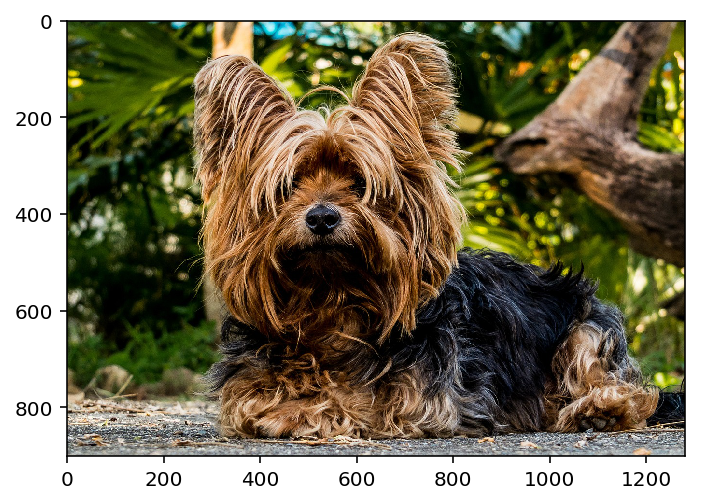

This dog looks like 3.Bouvier_des_flandres


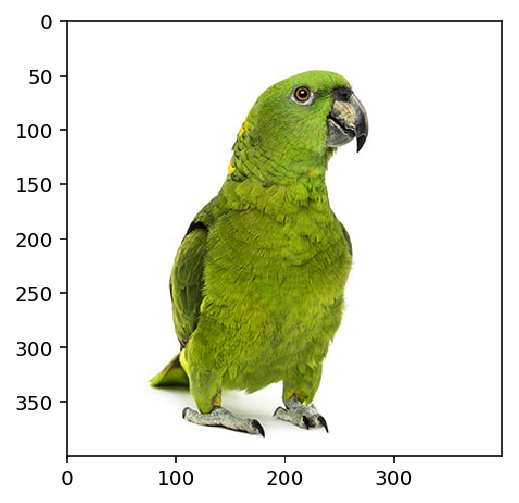

This neither dog nor human!


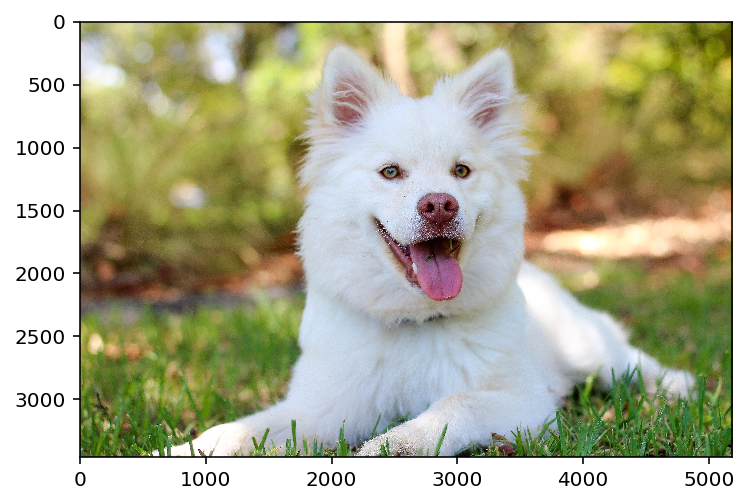

This dog looks like 6.American_eskimo_dog


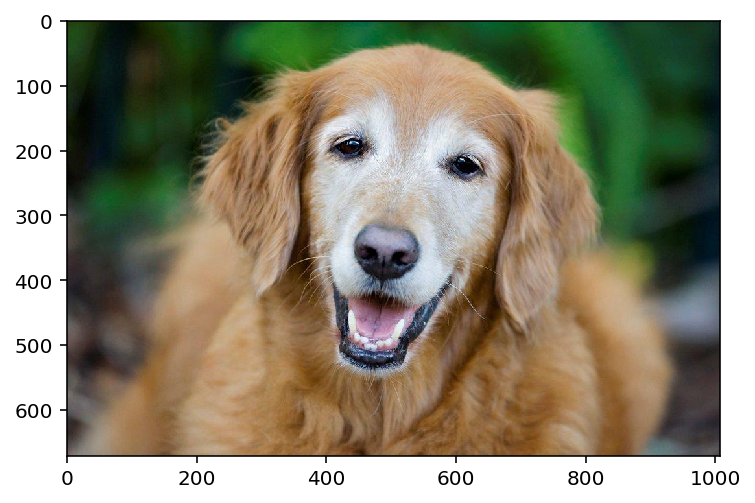

This dog looks like 5.Kuvasz


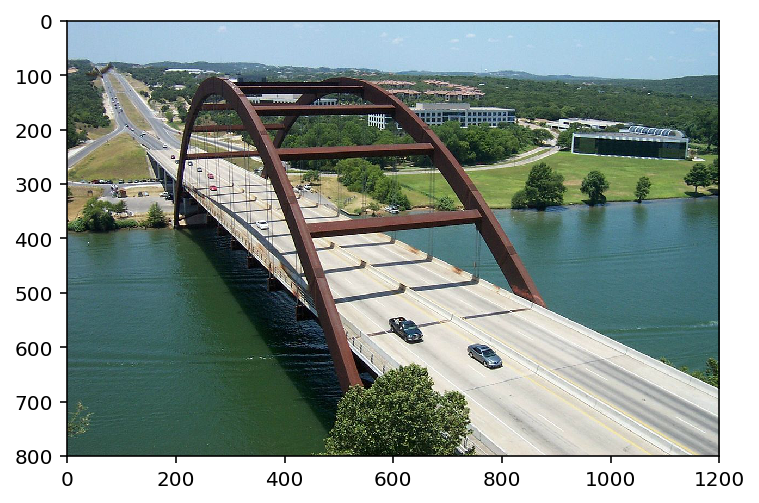

This neither dog nor human!


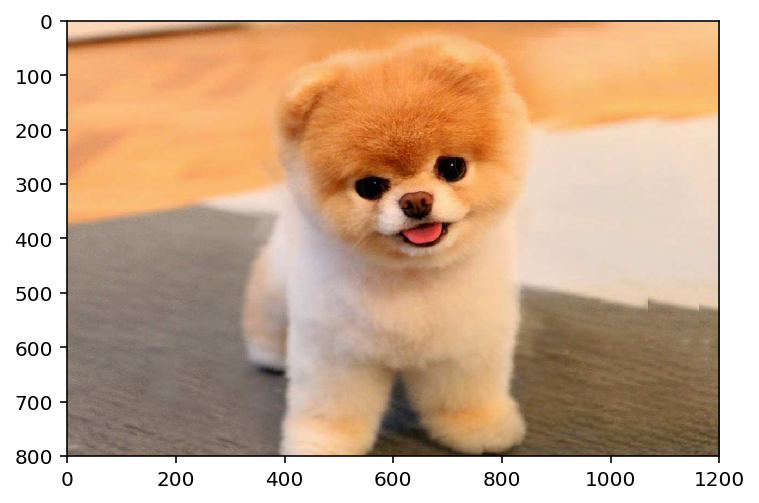

This dog looks like 4.Bichon_frise


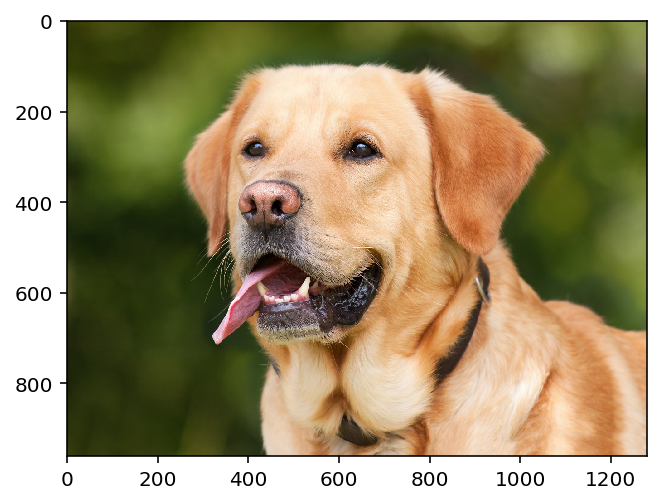

This dog looks like 6.Labrador_retriever


In [45]:
# TEST
for path in glob("test_images/*"):
    print(detector(path))